<a href="https://colab.research.google.com/github/rajeshgayathri2003/EVPR/blob/main/Identifying_Minimum_SOC_required_at_a_given_node.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
net= pd.read_csv('/content/drive/MyDrive/FYP 2025/Sioux falls data/SiouxFalls_net.tntp', skiprows=8, sep='\t').drop(['~', ';'], axis =1)
net['edge']=net.index+1
net['length'] = net.length*5
flow=pd.read_csv('/content/drive/MyDrive/FYP 2025/Sioux falls data/SiouxFalls_flow.tntp',sep='\t').drop(['From ', 'To '],axis=1)
flow.rename(columns={"Volume ": "flow", "Cost ": "cost"},inplace=True)
node_coord=pd.read_csv('/content/drive/MyDrive/FYP 2025/Sioux falls data/SiouxFalls_node.tntp',sep='\t').drop([';'], axis=1) # Actual Sioux Falls coordinate
node_xy=pd.read_csv('/content/drive/MyDrive/FYP 2025/Sioux falls data/SiouxFalls_node_xy.tntp',sep='\t') # X,Y position for good visualization


In [ ]:
net

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge
0,1,2,25900.200640,30,6,0.15,4,0,0,1,1
1,1,3,23403.473190,20,4,0.15,4,0,0,1,2
2,2,1,25900.200640,30,6,0.15,4,0,0,1,3
3,2,6,4958.180928,25,5,0.15,4,0,0,1,4
4,3,1,23403.473190,20,4,0.15,4,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,5000.000000,20,4,0.15,4,0,0,1,72
72,23,24,5078.508436,10,2,0.15,4,0,0,1,73
73,24,13,5091.256152,20,4,0.15,4,0,0,1,74
74,24,21,4885.357564,15,3,0.15,4,0,0,1,75


In [ ]:
flow

,flow,cost
0,4494.657646,6.000816
1,8119.079948,4.008691
2,4519.079948,6.000834
3,5967.336396,6.573598
4,8094.657646,4.008587
...,...,...
71,9626.210200,12.243138
72,7902.983927,3.759304
73,11112.394731,17.617021
74,10259.524716,11.752579


In [ ]:
sioux_falls_df=pd.concat([net,flow], axis=1)
sioux_falls_df

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,25900.200640,30,6,0.15,4,0,0,1,1,4494.657646,6.000816
1,1,3,23403.473190,20,4,0.15,4,0,0,1,2,8119.079948,4.008691
2,2,1,25900.200640,30,6,0.15,4,0,0,1,3,4519.079948,6.000834
3,2,6,4958.180928,25,5,0.15,4,0,0,1,4,5967.336396,6.573598
4,3,1,23403.473190,20,4,0.15,4,0,0,1,5,8094.657646,4.008587
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,5000.000000,20,4,0.15,4,0,0,1,72,9626.210200,12.243138
72,23,24,5078.508436,10,2,0.15,4,0,0,1,73,7902.983927,3.759304
73,24,13,5091.256152,20,4,0.15,4,0,0,1,74,11112.394731,17.617021
74,24,21,4885.357564,15,3,0.15,4,0,0,1,75,10259.524716,11.752579


In [ ]:
def create_graph(sioux_falls_df):
    # Create graph
    G = nx.from_pandas_edgelist(sioux_falls_df, 'init_node', 'term_node',
                                 ['capacity', 'length', 'free_flow_time', 'b', 'power', 'speed',
                                  'toll', 'link_type', 'edge', 'flow', 'cost'],
                                 create_using=nx.MultiDiGraph())

    # Coordinate positions
    pos_coord = {i: (a, b) for i, a, b in zip(node_coord.Node, node_coord.X, node_coord.Y)}
    pos_xy = {i: (a, b) for i, a, b in zip(node_xy.Node, node_xy.X, node_xy.Y)}

    # Assign positions as attributes
    for (n, p) in pos_coord.items():
        #n,p = pos_coord[key]
        G.nodes[n]['pos_coord'] = p

    for (n, p) in pos_xy.items():
        #n,p = pos_xy[key]
        G.nodes[n]['pos_xy'] = p

    # Define charging stations
    charging_stations = {2, 6, 12, 16}
    for n in G.nodes:
        G.nodes[n]['charging_station'] = (n in charging_stations)

    return G, pos_xy, charging_stations

In [ ]:
def plot_graph(G, pos):
    plt.figure(figsize=(12, 12))

    # Define node colors
    node_colors = ['red' if G.nodes[n]['charging_station'] else 'blue' for n in G.nodes]

    # Draw graph
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Sioux Falls Network with Charging Stations', fontsize=20)

    # Save figure
    plt.savefig('sioux-falls-network.png')
    plt.show()

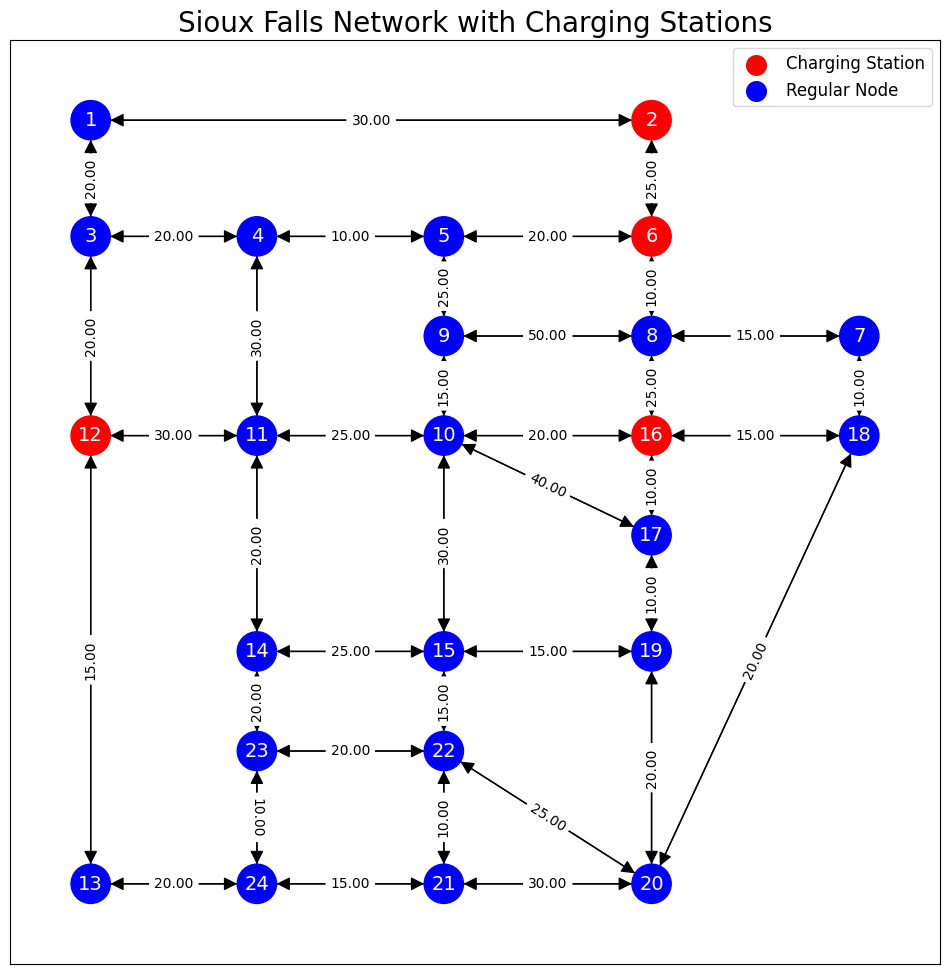

In [ ]:
G, pos,charging_stations = create_graph(sioux_falls_df)
plot_graph(G, pos)

In [ ]:
def find_all_paths(graph, start_state, goal_state):
    paths = list(nx.all_simple_paths(graph, source=start_state, target=goal_state))
    path_distances = []
    for idx, path in enumerate(paths, start=1):
        distance = sum(graph[path[i]][path[i + 1]][0]['length'] for i in range(len(path) - 1) if graph[path[i]][path[i + 1]])
        path_distances.append((idx, path, distance))
    return path_distances

In [ ]:
def train(graph, charging_stations, num_episodes, alpha, gamma, epsilon, epsilon_decay, num_nodes):
    Q = np.zeros((num_nodes, num_nodes))

    for episode in range(num_episodes):
        current_node = random.choice(list(graph.nodes))  # Start at a random node
        while current_node not in charging_stations:
            # Choose action (neighboring node) using ε-greedy
            neighbors = list(graph.neighbors(current_node))
            if random.uniform(0, 1) < epsilon:
                # Explore: randomly choose a neighboring node
                action = random.choice(neighbors)
            else:
                # Exploit: choose the action with the highest Q-value
                action = max(neighbors, key=lambda x: Q[current_node-1][x-1])

            # Select a random edge between current_node and action
            edges = list(graph.get_edge_data(current_node, action).values())
            selected_edge = random.choice(edges)  # Randomly select one edge

            # Reward function: positive if reaching a charging station, negative edge weight otherwise
            weight = selected_edge.get('length')  # Default weight if not provided
            reward = 100 if action in charging_stations else -weight

            # Update Q-Table
            next_node = action
            Q[current_node-1][action-1] += alpha * (reward + gamma * np.max(Q[next_node-1]) - Q[current_node-1][action-1])

            # Move to the next node
            current_node = next_node

        # Decay epsilon
        epsilon *= epsilon_decay

    return Q


In [ ]:
alpha = 0.1        # Learning rate
gamma = 0.9        # Discount factor
epsilon = 1.0      # Exploration rate
epsilon_decay = 0.99
num_episodes = 1000
num_nodes = 24     # Example number of nodes

Q = train(G, charging_stations, num_episodes, alpha, gamma, epsilon, epsilon_decay, num_nodes)

In [ ]:
def find_nearest_charging_station(graph, start_node, Q, charging_stations):
    current_node = start_node
    path = [current_node]
    total_cost = 0

    while current_node not in charging_stations:
        # Choose the best action (neighboring node) based on the Q-table
        neighbors = list(graph.neighbors(current_node))
        action = max(neighbors, key=lambda x: Q[current_node - 1][x - 1])  # Adjust for zero-indexed Q-table

        # Select the minimum weight edge between current_node and action
        edges = list(graph.get_edge_data(current_node, action).values())
        min_weight_edge = min(edges, key=lambda edge: edge.get('length'))  # Default weight is 1 if not provided

        # Add the minimum edge weight to the total cost
        total_cost += min_weight_edge.get('length')

        # Move to the next node
        current_node = action
        path.append(current_node)

    return path, total_cost


In [ ]:
Q[3,:]

array([ 0.        ,  0.        ,  3.14108868,  0.        , 76.2551413 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.59613417,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
costs = {}
paths = {}
for start_node in range(1,25):
  if start_node not in charging_stations:
    path, total_cost = find_nearest_charging_station(G, start_node, Q, charging_stations)
    print(start_node, total_cost)
    costs[start_node] = total_cost
    paths[start_node] = path

print("Shortest Path:", paths)
print("Total Cost:", costs)

1 30
3 20
4 30
5 20
7 25
8 25
9 35
10 20
11 30
13 15
14 50
15 50
17 10
18 15
19 20
20 35
21 50
22 60
23 45
24 35
Shortest Path: {1: [1, 2], 3: [3, 12], 4: [4, 5, 6], 5: [5, 6], 7: [7, 18, 16], 8: [8, 16], 9: [9, 10, 16], 10: [10, 16], 11: [11, 12], 13: [13, 12], 14: [14, 11, 12], 15: [15, 10, 16], 17: [17, 16], 18: [18, 16], 19: [19, 17, 16], 20: [20, 18, 16], 21: [21, 24, 13, 12], 22: [22, 21, 24, 13, 12], 23: [23, 24, 13, 12], 24: [24, 13, 12]}
Total Cost: {1: 30, 3: 20, 4: 30, 5: 20, 7: 25, 8: 25, 9: 35, 10: 20, 11: 30, 13: 15, 14: 50, 15: 50, 17: 10, 18: 15, 19: 20, 20: 35, 21: 50, 22: 60, 23: 45, 24: 35}


In [ ]:
max_length = max(total_cost for total_cost in costs.values())
max_length

60

In [ ]:
60*0.005

0.3